<a href="https://colab.research.google.com/github/ItoroKoffi/GraphRep/blob/main/GNNsolubility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to GNN solubilibity prediction
Link: https://medium.com/@tejpal.abhyuday/application-of-gnn-for-calculating-the-solubility-of-molecule-graph-level-prediction-8bac5fabf600

In [5]:
# import packages
#Install RDkit from pip install rdkit-pypi


!pip install rdkit
!pip install -q torch-geometric
!pip install -q py3Dmol

import rdkit
from torch_geometric.datasets import MoleculeNet

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import AllChem
import py3Dmol


import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

from torch_geometric.data import DataLoader
import warnings

import seaborn as sns

import pandas as pd


# Load and investigate the ESOL dataset

In [6]:
# Load the ESOL dataset
data = MoleculeNet(root=".", name="ESOL")
data

Processing...
Done!


ESOL(1128)

In [7]:
# Investigate the ESOL dataset
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)


Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  734
Dataset length:  <bound method InMemoryDataset.len of ESOL(1128)>
Dataset sample:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Sample  nodes:  32
Sample  edges:  68


/usr/local/lib/python3.12/dist-packages/torch_geometric/data/in_memory_dataset.py:91: UserWarning: Found floating-point labels while calling `dataset.num_classes`. Returning the number of unique elements. Please make sure that this is expected before proceeding.
  return self._infer_num_classes(self._data.y)


We can see there are 9 features per node of the graph and we have total of 734 graphs. We have a target dimension of size 734 means for every graph we have some solubility (numerical ) value in the solvent.

In [8]:
# Investiagte the features of the node of graph
data[0].x

# Investigating the edges in sparse COO (or triplet/triad) format.
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html
# They provide only i and j, and ignore the value (A) because it is 1 for the adjacency matrix.
# Shape [2, num_edges]
data[0].edge_index.t()

# See the target value of data[0]
data[0].y

print(data[1127])
data[1127].x.shape, data[1127].edge_index.t().shape, data[1127].y.shape

Data(x=[19, 9], edge_index=[2, 38], edge_attr=[38, 3], smiles='COP(=O)(OC)OC(=CCl)c1cc(Cl)c(Cl)cc1Cl', y=[1, 1])


(torch.Size([19, 9]), torch.Size([38, 2]), torch.Size([1, 1]))

In [9]:
data[1127].edge_attr

tensor([[ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 2,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 2,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  1],
        [ 1,  0,  1],
        [ 2,  0,  1],
        [ 1,  0,  1],
        [ 2,  0,  1],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [ 1,  0,  0],
        [12,  0,  1],
        [ 1,  0,  0],
        [12,  0,  1],
        [ 1,  0,  0],
        [12,  0,  1],
        [ 1,  0,  0],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [ 1,  0,  0],
        [ 1,  0,  0]])

We will perform predictions based on the graph level. This means we have one y-label for the whole graph.
# Converting SMILES to RDKit molecules — Visualizing molecules
We want to have our SMILES molecules as graphs…

In [10]:
data[0]["smiles"]

'OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '

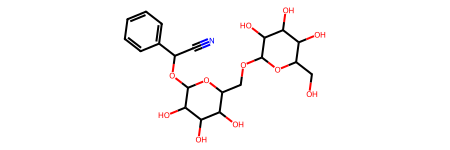

In [11]:
molecule = Chem.MolFromSmiles(data[0]["smiles"])
molecule

In [12]:
# Code to visualize ball and stick model of molecules
mol3d = Chem.AddHs(molecule)
AllChem.EmbedMolecule(mol3d, AllChem.ETKDGv3())
AllChem.UFFOptimizeMolecule(mol3d)
mb = Chem.MolToMolBlock(mol3d)

view = py3Dmol.view(width=900, height=720)
view.addModel(mb, 'sdf')
view.setStyle({'stick': {'radius': 0.2}, 'sphere': {'scale': 0.35}})
view.setBackgroundColor('white')
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

We have seen how to visualize our SMILE string into original molecule

How to use RDkit to extract features from the molecule

It provides all the information we require, such as edges, atom properties (type,…), etc.
Nevertheless, in our instance, it’s even simpler because the dataset already contains the information that’s been expressly provided.
Instead, we would use those atom attributes to calculate the node features.

# Implementation of Graph Neural Network
The process for creating a Graph Neural Network is very similar to that of a Convolutional Neural Network; we simply add more layers.

The GCN simply extends torch.nn.Module. GCNConv expects:

in_channels = Size of each input sample.
out_channels = Size of each output sample.
We use three convolutional layers, which means that we gain knowledge of three neighbor hops. In order to do graph-level prediction, we then apply a pooling layer to mix the data from the individual nodes.

We will use pytorch and pytorch geometric for our task



In [13]:
embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)

        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index),
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13249


In [28]:
# Modifying above code to use a for loop to display the shape and number of elements in the model parameter of each layer of the model.

for name, p in model.named_parameters():
  print(f"Layer {name} has shape of {p.shape} and {p.numel()} number of elements")
  print("=========================================================================")

Layer initial_conv.bias has shape of torch.Size([64]) and 64 number of elements
Layer initial_conv.lin.weight has shape of torch.Size([64, 9]) and 576 number of elements
Layer conv1.bias has shape of torch.Size([64]) and 64 number of elements
Layer conv1.lin.weight has shape of torch.Size([64, 64]) and 4096 number of elements
Layer conv2.bias has shape of torch.Size([64]) and 64 number of elements
Layer conv2.lin.weight has shape of torch.Size([64, 64]) and 4096 number of elements
Layer conv3.bias has shape of torch.Size([64]) and 64 number of elements
Layer conv3.lin.weight has shape of torch.Size([64, 64]) and 4096 number of elements
Layer out.weight has shape of torch.Size([1, 128]) and 128 number of elements
Layer out.bias has shape of torch.Size([1]) and 1 number of elements


Since we have huge molecules, we use 64 embeddings rather than the option to minimize them.
We gain more knowledge about the graph as we add more levels.
We utilize a linear layer as the final output layer for the regression problem.
Although we only have about 1,000 samples, we strive to use as few parameters as possible.
# Training of GNN


In [29]:

warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)],
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):],
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)
      # Reset gradients
      optimizer.zero_grad()
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
      # Calculating the loss and gradients
      loss = loss_fn(pred, batch.y)
      loss.backward()
      # Update using the gradients
      optimizer.step()
    return loss, embedding

print("Starting training...")
losses = []
for epoch in range(2000):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 11.665947914123535
Epoch 100 | Train Loss 0.8504207730293274
Epoch 200 | Train Loss 1.1154390573501587
Epoch 300 | Train Loss 0.32911959290504456
Epoch 400 | Train Loss 0.23744039237499237
Epoch 500 | Train Loss 0.38848552107810974
Epoch 600 | Train Loss 0.22591347992420197
Epoch 700 | Train Loss 0.06603380292654037
Epoch 800 | Train Loss 0.161929190158844
Epoch 900 | Train Loss 0.1568988561630249
Epoch 1000 | Train Loss 0.046887725591659546
Epoch 1100 | Train Loss 0.03903582692146301
Epoch 1200 | Train Loss 0.15991733968257904
Epoch 1300 | Train Loss 0.08483908325433731
Epoch 1400 | Train Loss 0.04848349094390869
Epoch 1500 | Train Loss 0.018160203471779823
Epoch 1600 | Train Loss 0.02361152321100235
Epoch 1700 | Train Loss 0.02528112567961216
Epoch 1800 | Train Loss 0.04550778865814209
Epoch 1900 | Train Loss 0.05733415484428406


In [33]:
epoch

1999

# Visualize Training loss

<Axes: xlabel='epoch', ylabel='loss'>

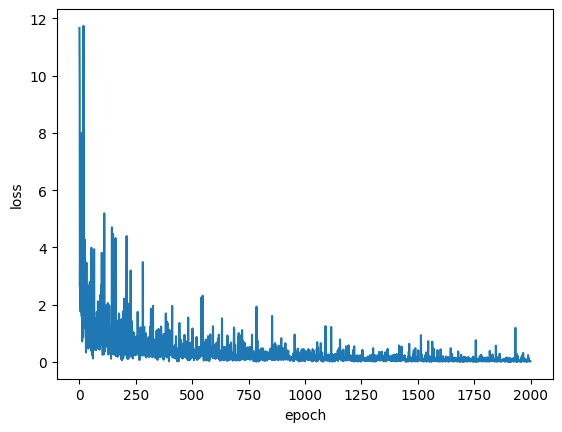

In [34]:
# Visualize learning (training loss)

losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i,l in enumerate(losses_float)]
loss_pd = pd.DataFrame({"epoch": loss_indices, "loss": losses_float})
plt = sns.lineplot(data=loss_pd, x="epoch", y="loss")
plt

# Prediction of Test Data

In [35]:


# Analyze the results for one batch
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df


,y_real,y_pred
0,-2.570,-2.147978
1,-1.470,-0.955594
2,-5.410,-3.088553
3,0.610,-0.483306
4,-5.230,-3.953741
...,...,...
59,-1.920,-1.951882
60,-4.230,-3.656125
61,-4.554,-3.402268
62,-1.960,-1.341877


Let’s visualize the y_pred and y_original

<Axes: xlabel='y_real', ylabel='y_pred'>

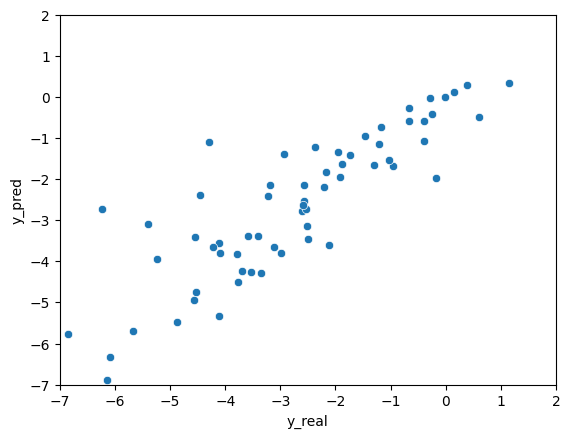

In [36]:
plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))
plt

In [38]:
#Modification of code to compute and display the R2 and RMSE of the predicted values.

import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

y_pred = df['y_pred'].values
y_real = df['y_real'].values
rmse = np.sqrt(mean_squared_error(y_real, y_pred))
r2= r2_score(y_real, y_pred)

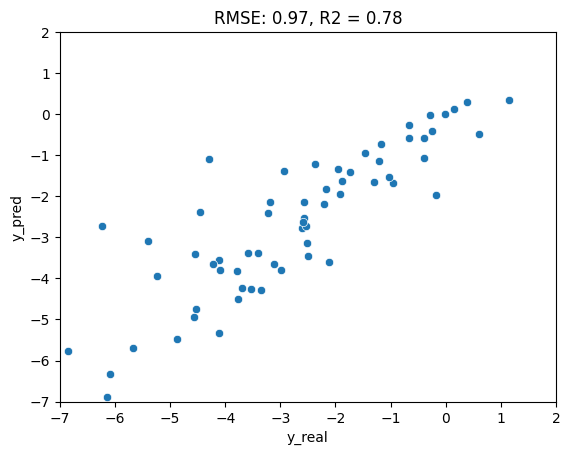

In [44]:
plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))
#plt.xlabel("Actual")
#plt.ylabel("Predicted")
plt.set_title(f"RMSE: {rmse:.2f}, R2 = {r2:.2f}")

plt;